In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp
import time

# Define Domain
# Space
Xpts = int(1e2)  # Grid Points
X0, Xf = 0, 10  # Domain
Xlng = Xf-X0
dx = Xlng/Xpts  # Grid Size
x = np.arange(X0, Xf, dx)  # Spatial Domain

# Time
dt = 1e-3  # Time Step Size
T0, Tf = 0, 1  # Domain
Tlng = Tf-T0
Tpts = int(Tlng/dt)  # Time Steps
t = np.linspace(T0, Tf, num=Tpts, endpoint=False)

# Numerical Parameters
xx, tt = np.meshgrid(x,t, sparse=False, indexing='xy') # Spatial-Temporal Domain
lmbd = dt / dx # 1e2/2.5e2 = .4
n_0 = 3 / (4 * np.pi)
Gamma_0 = 1 # input("Enter Gamma_0: ")
kappa_0 = 1 # input("Enter kappa_0: ")
beta = 1

# Correlation Parameters
k_fft_norm = 2*np.pi/(Xpts*dx)
k = k_fft_norm * np.linspace(-Xpts/2, Xpts/2-1,Xpts)  # Fourier Domain
x3 = np.linspace(-Xlng, 2*Xlng, 3*Xpts-2)  # Correlation Domain

print(lmbd)

0.01


In [2]:
def memoryPDE(u_IC):
    u = np.zeros((2,Tpts,Xpts))
    u[:,0] = np.copy(u_IC)
    Fu = np.zeros((2,Tpts,Xpts))
    return u, Fu

In [3]:
# Initial Conditions
disp_freq = 3 * 2 * np.pi / Xlng
n_IC = n_0*np.ones(Xpts) + .2*np.sin(disp_freq * x)
v_IC = np.sin(disp_freq *
              x)
# v_IC = np.zeros(Xpts)
# v_IC[0:int(Xpts/2)] = 1 
# n_IC = n_0 * np.ones(Xpts) + .1 * (np.random.rand(Xpts))
# v_IC = .1 * (np.random.rand(Xpts))
# n_IC = n_0*np.ones(Xpts) + .1*np.sin(disp_freq * x)
# n_IC[int(Xpts/2):Xpts] /= 10
# v_IC = 10*np.ones(Xpts) + np.sin(disp_freq * x)
# v_IC[int(Xpts/2):Xpts] /= 10


# Memory Allocation
n, Fn = memoryPDE(n_IC)
v, Fv = memoryPDE(v_IC)
phi = np.zeros((2,Tpts,Xpts))
f_corr = np.zeros((Tpts, Xpts))
rhs = np.zeros((2,Tpts,Xpts))
jacobian = np.zeros((Xpts,2,2))
jacobian_ref = np.zeros((Xpts,2))
P = np.zeros((Xpts,2,2))
L = np.zeros((Xpts,2,2))
U = np.zeros((Xpts,2,2))
D = np.zeros((Xpts,2,2))
absD = np.zeros((Xpts,2,2))
absA = np.zeros((Xpts,2,2))
diff = np.zeros((Xpts,2))
Flux = np.zeros((Xpts,2))

godunov_flux = np.zeros((2,2,Tpts,Xpts)) #eq,c,t,x
flux_n = np.zeros((2,Tpts,Xpts)) #eq,c,t,x
flux_v = np.zeros((2,Tpts,Xpts)) #eq,c,t,x

In [4]:
# =============== #
# Solve Functions #
# =============== #
def solve_phic(cor, cur_time, un, uphi):
    uphi_c_cur = uphi[cor,cur_time]
    un_c_cur = un[cor,cur_time]
    A = np.zeros(Xpts)
    # Define b
    b = 3 - 4 * np.pi * dx * dx * un_c_cur
    b = b - np.mean(b)
    # First sweep
    A[0] = -0.5
    b[0] = -0.5 * b[0]
    for ii in range(1, Xpts):
        A[ii] = -1 / (2 + A[ii - 1])
        b[ii] = (b[ii - 1] - b[ii]) / (2 + A[ii - 1])
    # Second sweep
    uphi_c_cur[0] = b[Xpts - 1] - b[Xpts - 2]
    for ii in range(1, Xpts - 1):
        uphi_c_cur[ii] = (b[ii - 1] - uphi_c_cur[ii - 1]) / A[ii - 1]
    return uphi_c_cur

def nonisotropic_correlations(unc, cur_time, n3, x, x3,f_corr):
    conc = unc / n_0
    Gamma = Gamma_0 * conc ** (1 / 3)
    kappa = kappa_0 * conc ** (1 / 6)

    n3[0:N] = unc[cur_time]
    n3[N:2 * N] = unc[cur_time]
    n3[2 * N:3 * N] = unc[cur_time]
    for jj in range(N):
        rho_int = - 2 * np.pi * Gamma[jj] * np.exp(- kappa[jj] * np.abs(x3 - x[jj])) / kappa[jj]
        f_corr[jj] = dx * np.sum(n3 * rho_int)
    return f_corr

def fft_meanfield(k,nctt,Gamma, kappa):
    delta_n = nctt - n_0
    def dcf(k, Gamma, kappa):
        return 4 * np.pi * Gamma / (k ** 2 + kappa ** 2)

    dcfunc = dcf(k,Gamma,kappa)
    fhat = np.fft.fftshift(np.fft.fft(delta_n))
    conv = fhat * dcfunc
    conv = np.fft.ifft(np.fft.ifftshift(conv))
    conv = np.real(conv)
    return conv

def fft_meyerf(k,nc,Gamma, kappa, beta):
    delta_n = nc - n_0

    # f_fft_norm = 1 / dx
    # k_fft_norm = 2 * np.pi / (N * dx)

    # Parameters
    Nr = int(1e3)
    rmax = 100  # TODO: Change per loop
    r = np.linspace(0, rmax, Nr)

    dcf = np.exp(-beta * r ** 2)
    dcf_fft = np.fft.fftshift(np.fft.fft(dcf))
    dcf_fft_ex = (np.pi / beta) ** (3 / 2) * np.exp(- k ** 2 / (4 * beta))

    n_hat = np.fft.fftshift(np.fft.fft(delta_n))
    conv = n_hat * dcf_fft
    conv = np.fft.ifft(np.fft.ifftshift(conv))
    conv = np.real(conv)
    return conv

def godunov(uctt, Fuctt):
    ugodunovctt = np.zeros((Xpts))
    for ii in range(Xpts): # Iterate over spacial values
        if uctt[ii-1] > uctt[ii]: 
            ugodunovctt[ii] = np.maximum(Fuctt[ii-1], Fuctt[ii])
        elif uctt[ii-1] < uctt[ii]:
            ugodunovctt[ii] = np.minimum(Fuctt[ii-1], Fuctt[ii])
        else:
            ugodunovctt[ii] = 0.0
        return ugodunovctt

In [5]:
# ===== #
# Solve #
# ===== #
st = time.time()
for c in range(2): # Iterate through correlations
    for tt in range(1,600): # Iterate Time
    # for tt in range(1,5): # Iterate Time
  
        # Roe Solver Flux
        Fn[c,tt] = n[c,tt-1]*v[c,tt-1]
        Fv[c,tt] = .5*v[c,tt-1]*v[c,tt-1]+np.log(np.abs(n[c,tt-1]))
        
        nonlin_flux = np.stack((Fn[c,tt],Fv[c,tt]))
        vec = np.stack((n[c,tt],v[c,tt]))
        
#         dFn = Fn[c,tt] - np.roll(Fn[c,tt],1)
#         dFv = Fv[c,tt] - np.roll(Fv[c,tt],1)
#         dn = n[c,tt-1] - np.roll(n[c,tt-1],1)
#         dv = v[c,tt-1] - np.roll(v[c,tt-1],1)
        
#         dFndn = dFn/dn
#         dFvdn = dFv/dn
#         dFndv = dFn/dv
#         dFvdv = dFv/dv
#         for ii in range(Xpts):
#             dFndn[np.where(~np.isfinite(dFndn[ii]))] = v[c,tt,ii]
#             dFndv[np.where(~np.isfinite(dFndv[ii]))] = n[c,tt,ii]
#             dFvdn[np.where(~np.isfinite(dFvdn[ii]))] = 1/n[c,tt,ii]
#             dFvdv[np.where(~np.isfinite(dFvdv[ii]))] = v[c,tt,ii]

        dFn = Fn[c,tt] - np.roll(Fn[c,tt],1)
        dFv = Fv[c,tt] - np.roll(Fv[c,tt],1)
        dn = n[c,tt-1] - np.roll(n[c,tt-1],1)
        dv = v[c,tt-1] - np.roll(v[c,tt-1],1)
        
        dFndn = v[c,tt-1]
        dFndv = n[c,tt-1]
        dFvdn = 1/n[c,tt-1]
        dFvdv = v[c,tt-1]
        
        num_used = ~(np.isfinite(dFndn.any()) or np.isfinite(dFndv.any()) or np.isfinite(dFvdn.any()) or np.isfinite(dFvdv.any()))
        
        if num_used:
            print("Numerical Jacobian Needed at",tt)
            # print(dFndn)
            # print(dFvdn)
            # print(dFndv)
            # print(dFvdv)
            
        for ii in range(Xpts):
            dFndn[np.where(~np.isfinite(dFndn[ii]))] = dFn[ii]/dn[ii]
            dFndv[np.where(~np.isfinite(dFndv[ii]))] = dFv[ii]/dn[ii]
            dFvdn[np.where(~np.isfinite(dFvdn[ii]))] = dFn[ii]/dv[ii]
            dFvdv[np.where(~np.isfinite(dFvdv[ii]))] = dFv[ii]/dv[ii]

        for ii in range(Xpts-1):
            jacobian[ii] = np.array([[dFndn[ii],dFndv[ii]],[dFvdn[ii],dFvdv[ii]]])            
            P[ii], D[ii] = sp.Matrix.diagonalize(sp.Matrix(jacobian[ii]))
            if num_used:
                
                print(jacobian[ii])
                print(P[ii])
                print(D[ii])
                num_used = False
            absD[ii] = np.abs(D[ii])
            absA[ii] = np.matmul(P[ii],np.matmul(absD[ii],np.linalg.inv(P[ii])))
            diff[ii] = np.dot(absA[ii],vec[:,ii+1]-vec[:,ii])/2
            Flux[ii] = (nonlin_flux[:,ii+1] - nonlin_flux[:,ii])/2 - diff[ii]
        jacobian[Xpts-1] = np.array([[dFndn[ii],dFndv[ii]],[dFvdn[ii],dFvdv[ii]]])
        P[Xpts-1], D[Xpts-1] = sp.Matrix.diagonalize(sp.Matrix(jacobian[Xpts-1]))
        absD[Xpts-1] = np.abs(D[Xpts-1])
        absA[Xpts-1] = np.matmul(P[Xpts-1],np.matmul(absD[ii],np.linalg.inv(P[Xpts-1])))
        diff[Xpts-1] = np.dot(absA[Xpts-1],vec[:,0]-vec[:,Xpts-1])/2
        Flux[Xpts-1] = (nonlin_flux[:,0] - nonlin_flux[:,Xpts-1])/2 - diff[Xpts-1]
        
        #RHS
        phi[c,tt] = solve_phic(c,tt,n,phi)
        rhs[c,tt] = -Gamma_0*(phi[c,tt] - np.roll(phi[c,tt],1))/dx
        if c == 0:
            # f_corr = anisotropic_correlations(n,n3,x,x3,f_corr)
            f_corr[tt] = fft_meanfield(k,n[c,tt],Gamma_0,kappa_0)
            rhs[c,tt] += -(f_corr[tt] - np.roll(f_corr[tt],1))/dx
            
        #Update
        for ii in range(0,Xpts):
            # print(tt, Flux[ii,0] - Flux[ii-1,0])
            n[c,tt,ii] = n[c,tt-1,ii]-lmbd*(Flux[ii,0] - Flux[ii-1,0])
            v[c,tt,ii] = v[c,tt-1,ii]-lmbd*(Flux[ii,1] - Flux[ii-1,1])+dt*rhs[c,tt,ii]
            
        if ~np.isfinite(n[c,tt].any()):
            for time in range(5):
                rtime = time-2 
                print(tt,n[c,rtime])
                
        if  tt % int(Tpts/10) == 0:
            print(tt)
        if tt == 50:
            et = time.time()
            elapsed_time = et - st
            print('Execution time:', elapsed_time, 'seconds')
            print('Approximate total time:', Tpts/50*elapsed_time, 'seconds')

Execution time: 9.508710861206055 seconds
Approximate total time: 190.1742172241211 seconds
100
200
300
400
500
Execution time: 121.53177666664124 seconds
Approximate total time: 2430.6355333328247 seconds
100
200
300
400
500


In [6]:
# ============== #
# Plot Functions #
# ============== #

snaps = 20

def plot(ux, uc):
    fig = plt.figure(figsize=(15,15))
    plt.title('Γ = ' + str(Gamma_0) + ', κ = ' + str(kappa_0))
    for tt in range(Tpts):
        if tt % (Tpts / snaps) == 0:
            plt.plot(ux, uc[tt], label=str(tt/snaps))
    plt.legend()
    plt.show(block=False)

def cmap(ux, ut, uc): 
    fig = plt.figure(figsize=(15,15))
#    color_map = plt.contourf(ux, ut, u[c,:])
    color_map = plt.imshow(uc, cmap='viridis', origin='lower', extent=(X0,Xf,T0,Tf), aspect='auto')
    plt.title('Γ = ' + str(Gamma_0) + ', κ = ' + str(kappa_0))
    plt.colorbar()
    plt.ylabel("Time")
    plt.xlabel("Space")
    plt.show(block=False)    

def calculate_2dft(uc):
    fft = np.fft.ifftshift(uc-np.mean(uc[:]))
    fft = np.fft.fft2(fft)
    return np.abs(np.fft.fftshift(fft))

def disp_rel_cmap(ux, ut, uc):
    fft = calculate_2dft(uc)
    fig = plt.figure(figsize=(15,15))
    color_map = plt.contourf(ux, ut, fft)
    color_map = plt.imshow(fft, cmap='viridis', origin='lower', extent=(X0,Xf,T0,Tf), aspect='auto')
#    plt.title('Γ = ' + str(Gamma[ii]) + ', κ = ' + str(kappa[jj]))
    plt.title('Γ = ' + str(Gamma_0) + ', κ = ' + str(kappa_0))
    plt.colorbar()
    plt.ylabel("Time - Frequency")
    plt.xlabel("Space - Frequency")
    plt.show(block=False)
        
def plot3D():
    fig = plt.figure()
    

0.01


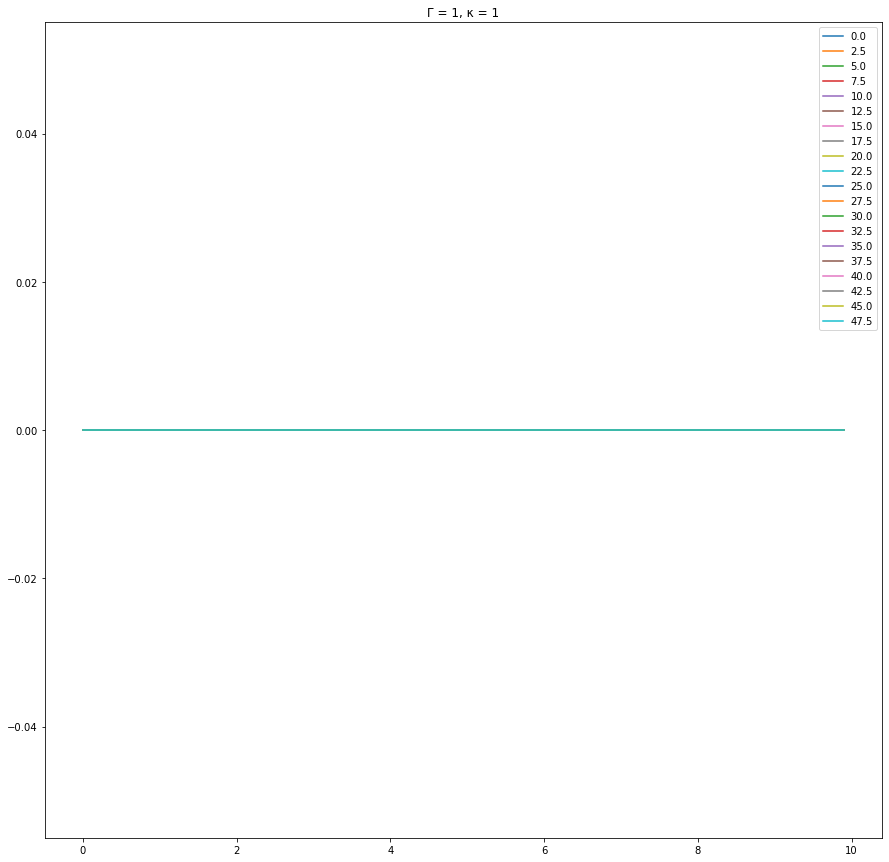

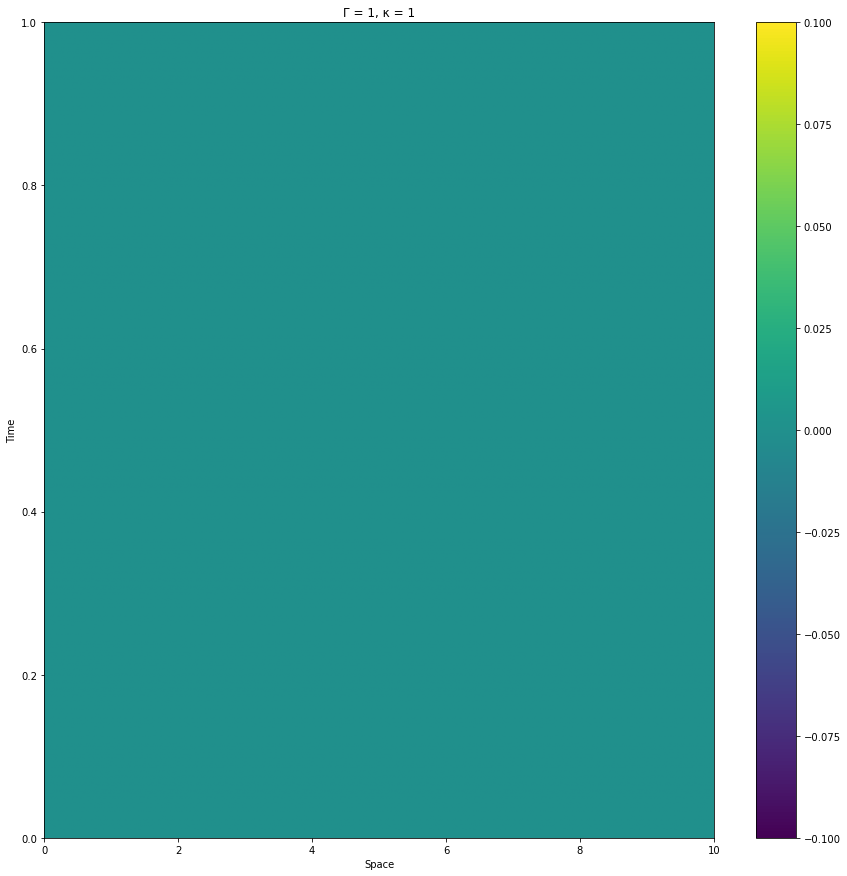

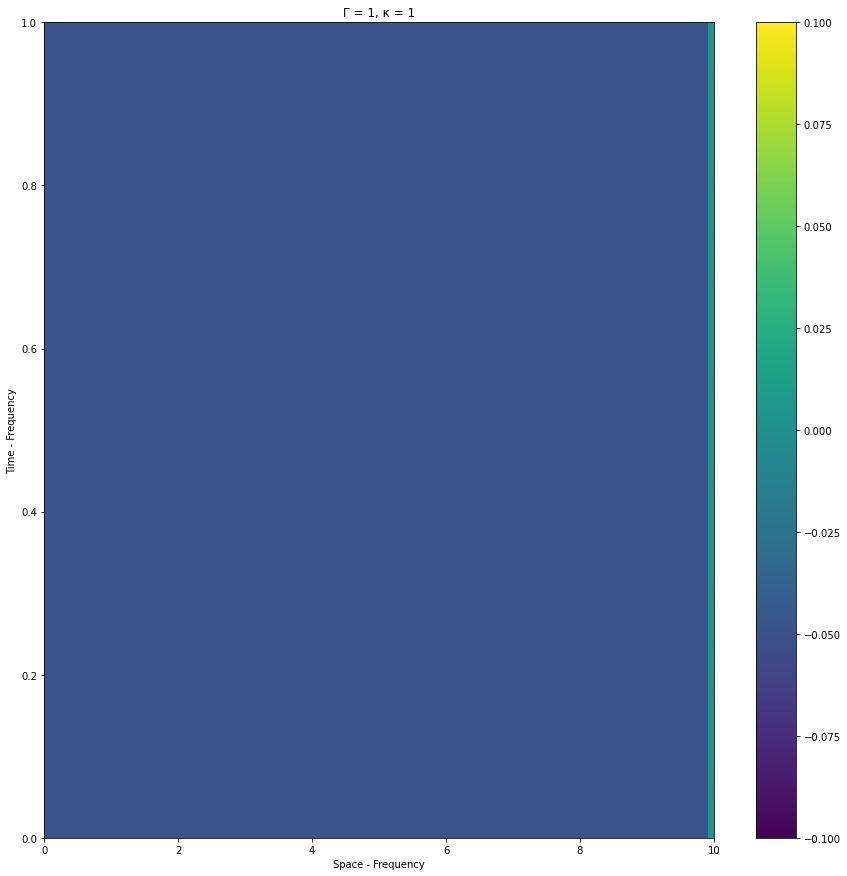

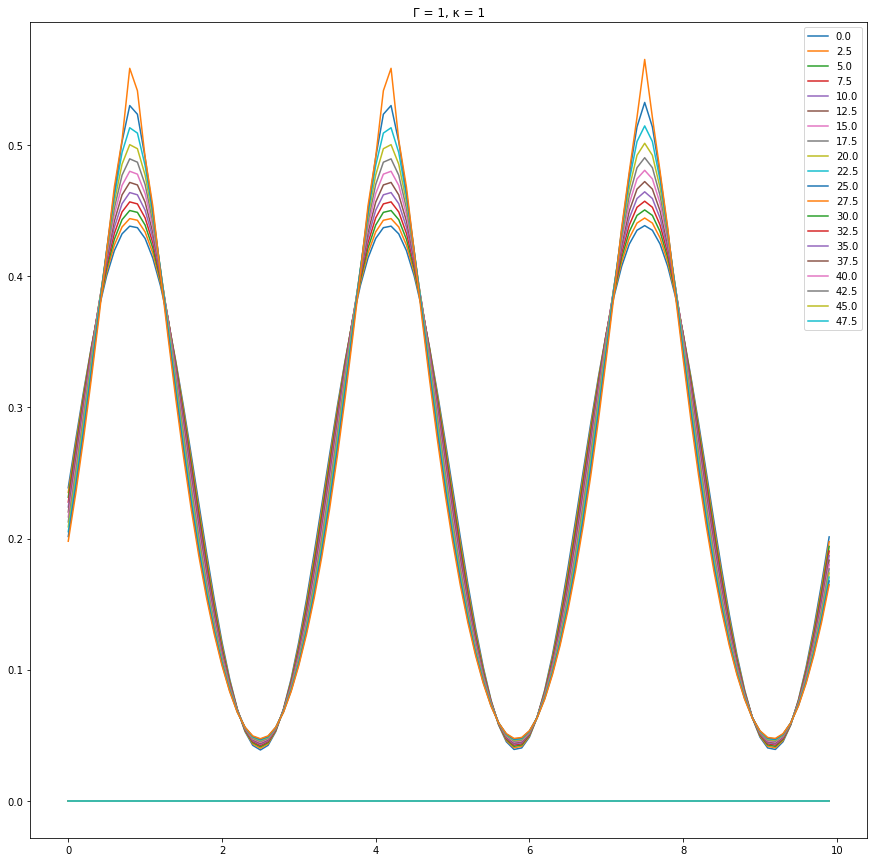

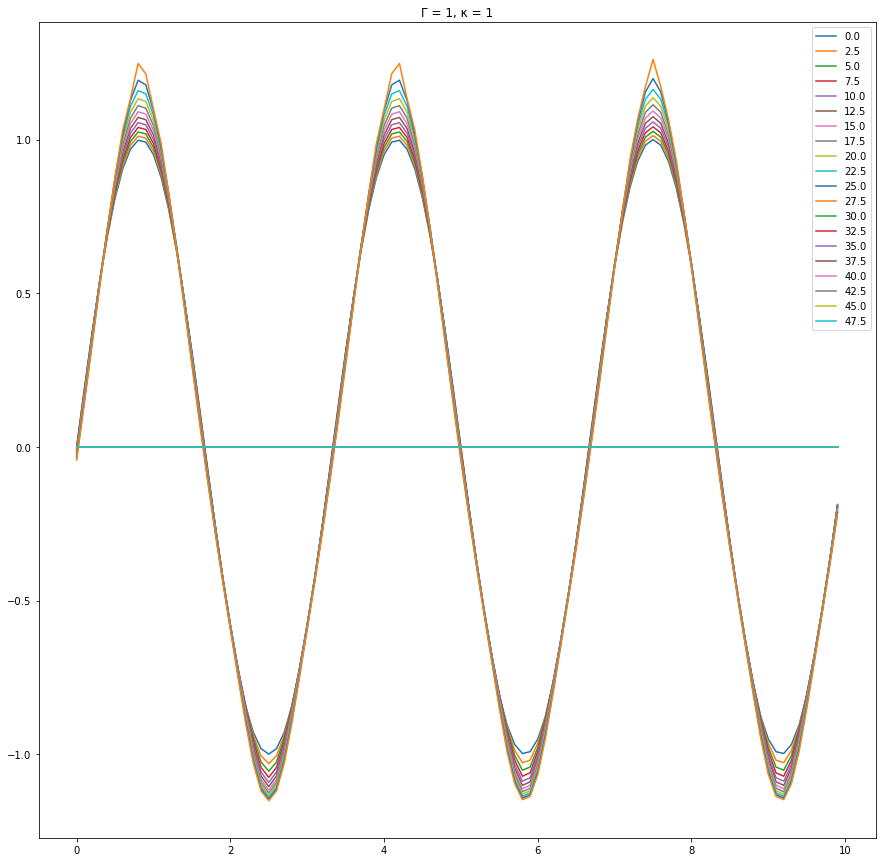

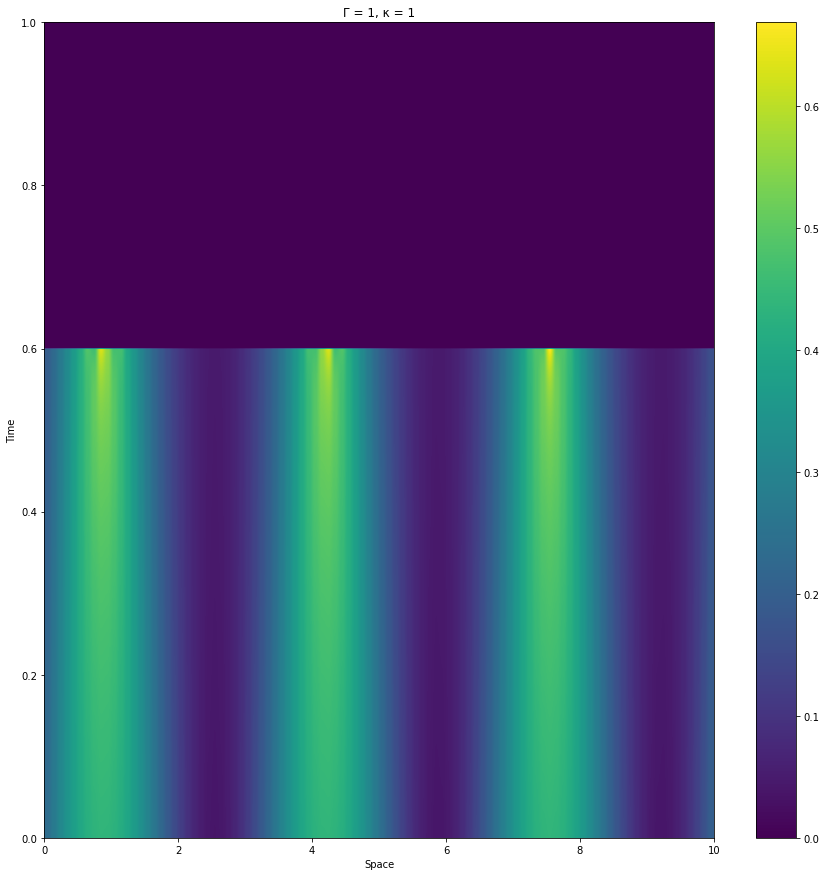

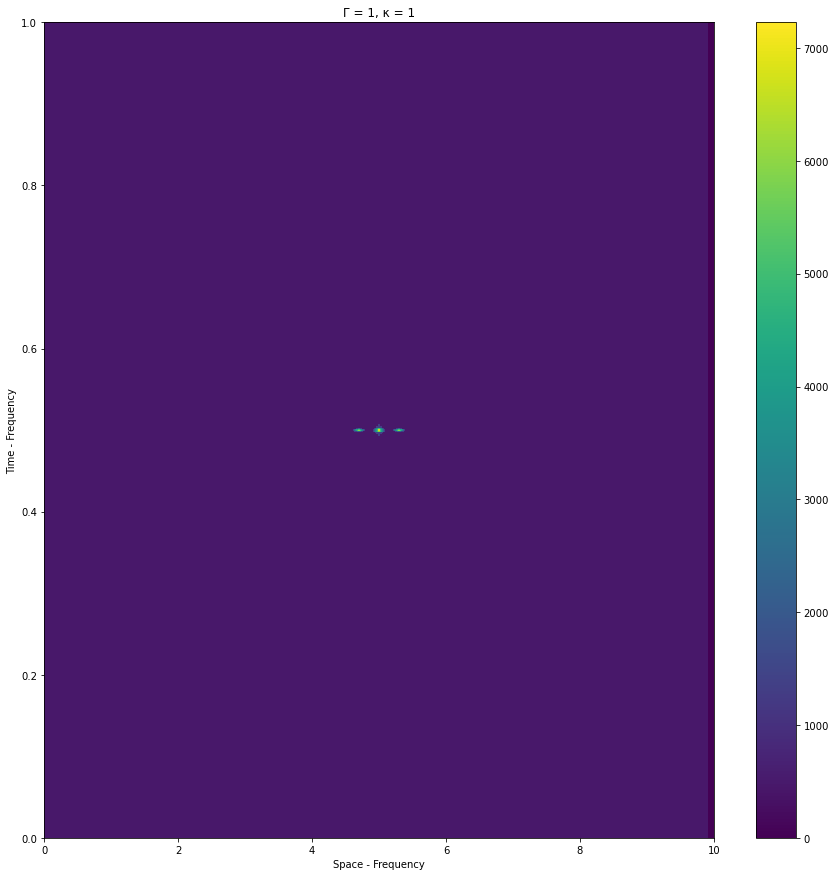

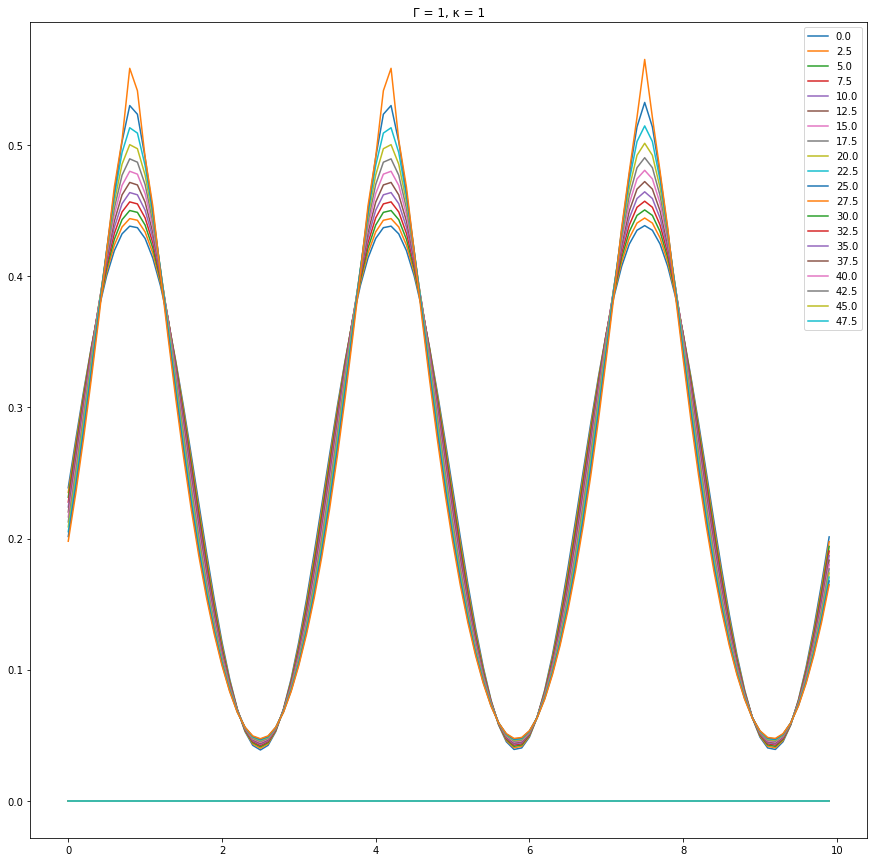

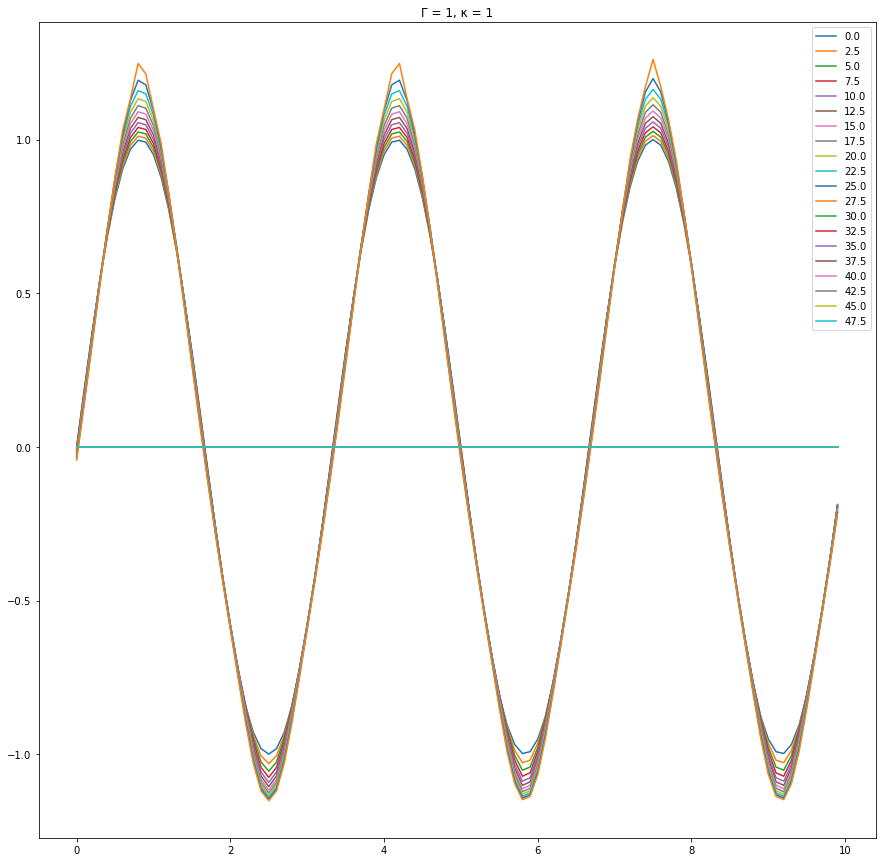

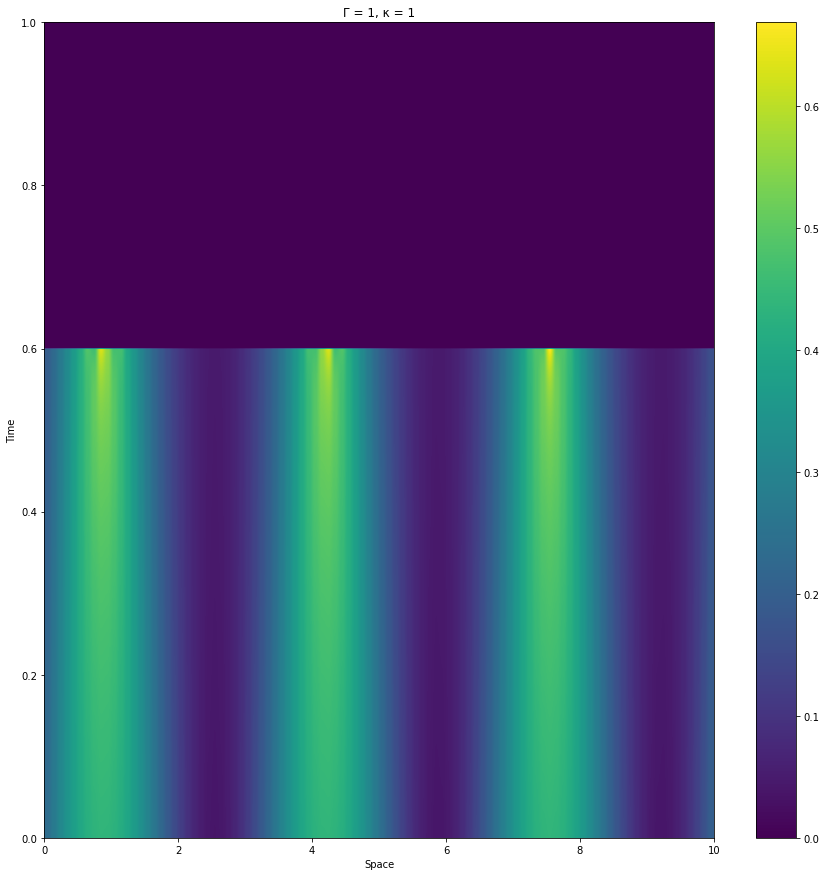

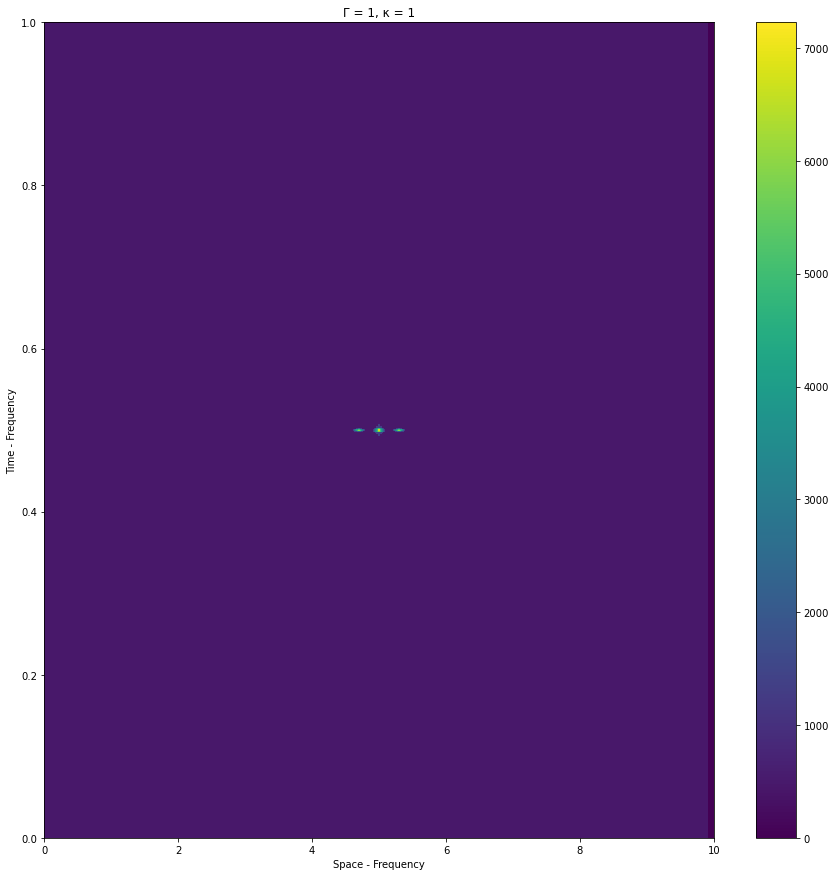

In [7]:
# ==== #
# Plot #
# ==== #

# plot(x[0:10],n[:,:,0:10])
print(lmbd)
plot(x,n[0]-n[1])
cmap(x,t,n[0]-n[1])
disp_rel_cmap(x,t,n[0]-n[1])
for c in range(2):
    plot(x,n[c])
    plot(x,v[c])
    cmap(x, t, n[c])
    disp_rel_cmap(x, t, n[c])

In [8]:
def subplot(u):
    fig, axes = plt.subplots(nrows=3, ncols=3)
    # find minimum of minima & maximum of maxima
    minmin = np.min(uc for uc in u)
    maxmax = np.max(uc for uc in u)
    for c in range(2):
        images = []
        for ii in range(3):
            for jj in range(3):
                im = axes[ii][jj].imshow(u[ii+jj], vmin=minmin, vmax=maxmax,
                                         extent=(X0,Xf,T0,Tf), aspect='auto', cmap='viridis')
                axes[ii][jj].set_title('Γ = ' + str(Gamma[ii]) + ', κ = ' + str(kappa[jj]))
                axes[ii][jj].set_ylabel("Time")
                axes[ii][jj].set_xlabel("Space")
                images.append(im)

        fig.tight_layout(pad = .01)
        fig.subplots_adjust(top=0.9)
        fig.suptitle("Density: Xpts Correlations")
        cbar = fig.colorbar(im, ax=axes.ravel().tolist(), shrink=1)
        plt.show(block=False)
    